In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data, DataLoader
from deepchem.feat import PagtnMolGraphFeaturizer


mol = pd.read_csv("/result.csv")

smiles = mol.drop_duplicates(subset = ['Pubid'], keep='first')
smiles = smiles['Smiles']

smiles_counts = mol['Smiles'].value_counts().reset_index()
pd.set_option('display.max_rows', None)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
<ipython-input-4-37c6c0c13ce4>:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  mol = pd.read_csv("/content/drive/My Drive/result.csv")


In [ ]:
from deepchem.feat import PagtnMolGraphFeaturizer


# Initialize the featurizer
featurizer = PagtnMolGraphFeaturizer(max_length=5)

# Apply the featurizer to the SMILES series
featurized_data = featurizer.featurize(smiles.tolist())

from deepchem.feat import PagtnMolGraphFeaturizer
import pandas as pd

# Initialize the featurizer
featurizer = PagtnMolGraphFeaturizer(max_length=5)

# Apply the featurizer to the SMILES series
featurized_data = featurizer.featurize(smiles.tolist())

Streaming output truncated to the last 5000 lines.
[10:06:52] DEPRECATION WARNING: please use GetValence(which=)
[10:06:52] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[10:06:52] DEPRECATION WARNING: please use GetValence(which=)
[10:06:52] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[10:06:52] DEPRECATION WARNING: please use GetValence(which=)
[10:06:52] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[10:06:52] DEPRECATION WARNING: please use GetValence(which=)
[10:06:52] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[10:06:52] DEPRECATION WARNING: please use GetValence(which=)
[10:06:52] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[10:06:52] DEPRECATION WARNING: please use GetValence(which=)
[10:06:52] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[10:06:52] DEPRECATION WARNING: please use GetValence(which=)
[10:06:52] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[10:

In [ ]:
results = []

for i, graph_data in enumerate(featurized_data):
    result = {
        "SMILES": smiles.iloc[i],
        "Node Features": graph_data.node_features.tolist(),  # Convert to list for storage
        "Edge Features": graph_data.edge_features.tolist(),   # Convert to list for storage
        "Edge Index": graph_data.edge_index.tolist()         # Convert to list for storage
    }
    results.append(result)

# Convert results to a DataFrame for better visualization or storage
results_df = pd.DataFrame(results)

# Save to a CSV or JSON file if needed
results_df.to_csv("node_edge_features.csv", index=False)

# Display the results
print(results_df.head())

                                              SMILES  \
0  COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...   
1  COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=C(OC)C=C1CN...   
2  CC/C(=C(\C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=...   
3  CC1=C(C2=CC=C(O)C=C2)N(CC2=CC=C(OCCN3CCCCCC3)C...   
4  OC1=CC=C2C(=C1)CC[C@H](C1=CC=CC=C1)[C@@H]2C1=C...   

                                       Node Features  \
0  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                       Edge Features  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
df = pd.merge(results_df, smiles_counts, left_on='SMILES', right_on='Smiles', how = 'left')
(df['count']).describe()

unique_interactions = mol.groupby("Compound ID")["gene_name"].nunique()

# Display results
df_dedup = unique_interactions.reset_index()
df['number_dedup'] = df_dedup['gene_name']
df['count_binned_custom'] = pd.cut(df['number_dedup'], bins=[0, 20, 60, 115], labels=[0, 1, 2])

graphs = []

for i, graph_data in enumerate(featurized_data):
    # Convert node features and edge indices into PyTorch tensors
    x = torch.tensor(graph_data.node_features, dtype=torch.float)  # Node features
    edge_index = torch.tensor(graph_data.edge_index, dtype=torch.long).t().contiguous()  # Edge index
    edge_attr = torch.tensor(graph_data.edge_features, dtype=torch.float)  # Edge features
    edge_index = edge_index.T
    y = torch.tensor(df['count_binned_custom'][i], dtype=torch.long)  # Target label

    # Create a PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    print(data)

    graphs.append(data)

# Create a DataLoader
loader = DataLoader(graphs, batch_size=32, shuffle=True)

Data(x=[26, 94], edge_index=[2, 676], edge_attr=[676, 42], y=0)
Data(x=[26, 94], edge_index=[2, 676], edge_attr=[676, 42], y=0)
Data(x=[28, 94], edge_index=[2, 784], edge_attr=[784, 42], y=2)
Data(x=[35, 94], edge_index=[2, 1225], edge_attr=[1225, 42], y=0)
Data(x=[31, 94], edge_index=[2, 961], edge_attr=[961, 42], y=0)
Data(x=[32, 94], edge_index=[2, 1024], edge_attr=[1024, 42], y=0)
Data(x=[33, 94], edge_index=[2, 1089], edge_attr=[1089, 42], y=0)
Data(x=[29, 94], edge_index=[2, 841], edge_attr=[841, 42], y=0)
Data(x=[31, 94], edge_index=[2, 961], edge_attr=[961, 42], y=0)
Data(x=[24, 94], edge_index=[2, 576], edge_attr=[576, 42], y=0)
Data(x=[32, 94], edge_index=[2, 1024], edge_attr=[1024, 42], y=1)
Data(x=[20, 94], edge_index=[2, 400], edge_attr=[400, 42], y=0)
Data(x=[31, 94], edge_index=[2, 961], edge_attr=[961, 42], y=0)
Data(x=[38, 94], edge_index=[2, 1444], edge_attr=[1444, 42], y=0)
Data(x=[31, 94], edge_index=[2, 961], edge_attr=[961, 42], y=0)
Data(x=[33, 94], edge_index=[2

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_classes):
        super(GAT, self).__init__()
        # Use GATConv which supports edge features
        self.conv1 = GATConv(num_node_features, hidden_channels, edge_dim=num_edge_features)
        self.conv2 = GATConv(hidden_channels, hidden_channels, edge_dim=num_edge_features)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # First graph convolution layer (with edge attributes)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)

        # Second graph convolution layer (with edge attributes)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        # Apply global mean pooling to aggregate node features
        x = global_mean_pool(x, batch)

        # Apply dropout for regularization
        x = F.dropout(x, p=0.5, training=self.training)

        # Linear layer to get final logits
        x = self.lin(x)

        # LogSoftmax for multi-class classification
        return F.log_softmax(x, dim=-1)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import random

# Create dataset
num_graphs = 172  # Adjust based on dataset size needs
# random.seed(5)  # or torch.manual_seed(42) for PyTorch's random number generator
# torch.manual_seed(5)
# Split into train and test sets
train_size = int(0.8 * num_graphs)
test_size = num_graphs - train_size
train_graphs, test_graphs = random_split(graphs, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

num_edge_features = graphs[0].edge_attr.size(1) if graphs[0].edge_attr is not None else 0

In [ ]:
def evaluate_more(model, loader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient computation
        for batch in loader:
            out = model(batch)  # Forward pass
            pred = out.argmax(dim=1)  # Get the predicted class
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

    return accuracy, precision, recall

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold
import os

# Create a directory to store the saved models
os.makedirs("cv_models_GAT_new", exist_ok=True)

# Define number of folds
num_folds = 5

# Convert dataset into indices for k-fold splitting
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store results for averaging later
accuracies, precisions, recalls = [], [], []

# Perform 5-fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
    print(f"\nFold {fold + 1}/{num_folds}")

    # Create train and validation sets
    train_subset = [graphs[i] for i in train_idx]
    val_subset = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize model (reinitialize for each fold to start fresh)
    model = GAT(num_node_features=graphs[0].num_node_features,
                num_edge_features=graphs[0].edge_attr.size(1) if graphs[0].edge_attr is not None else 0,
                hidden_channels=64,
                num_classes=3)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(70):  # Reduce epochs for faster CV
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Optionally save after each epoch
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"cv_models_GAT_new/model_fold{fold + 1}_epoch{epoch + 1}.pt")
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f} - Model saved.")

    # Save the model at the end of the fold
    torch.save(model.state_dict(), f"cv_models_GAT_new/model_fold{fold + 1}.pt")
    print(f"Fold {fold + 1} model saved.")

    # Evaluation on validation set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(batch.y.tolist())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold + 1} Precision: {precision:.4f}")
    print(f"Fold {fold + 1} Recall: {recall:.4f}")

    # Store results
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Print final averaged results across all folds
print("\nCross-Validation Results:")
print(f"Average Accuracy: {sum(accuracies) / num_folds:.4f}")
print(f"Average Precision: {sum(precisions) / num_folds:.4f}")
print(f"Average Recall: {sum(recalls) / num_folds:.4f}")

# Assuming you want to save the final model on the test data:
test_accuracy_gat, test_precision_gat, test_recall_gat = evaluate_more(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy_gat:.4f}")
print(f"Final Test Precision: {test_precision_gat:.4f}")
print(f"Final Test Recall: {test_recall_gat:.4f}")

# Save the final model after training
torch.save(model.state_dict(), f"cv_models_GAT_new/final_model.pt")
print("Final model saved.")


Fold 1/5
Epoch 1, Loss: 0.9161 - Model saved.
Epoch 11, Loss: 0.6096 - Model saved.
Epoch 21, Loss: 0.5333 - Model saved.
Epoch 31, Loss: 0.6079 - Model saved.
Epoch 41, Loss: 0.4607 - Model saved.
Epoch 51, Loss: 0.3956 - Model saved.
Epoch 61, Loss: 0.4243 - Model saved.
Fold 1 model saved.
Fold 1 Accuracy: 0.7714
Fold 1 Precision: 0.3822
Fold 1 Recall: 0.3722

Fold 2/5
Epoch 1, Loss: 0.8452 - Model saved.
Epoch 11, Loss: 0.7399 - Model saved.
Epoch 21, Loss: 0.5759 - Model saved.
Epoch 31, Loss: 0.5543 - Model saved.
Epoch 41, Loss: 0.5033 - Model saved.
Epoch 51, Loss: 0.5336 - Model saved.
Epoch 61, Loss: 0.6000 - Model saved.
Fold 2 model saved.
Fold 2 Accuracy: 0.8286
Fold 2 Precision: 0.2762
Fold 2 Recall: 0.3333

Fold 3/5
Epoch 1, Loss: 0.9264 - Model saved.
Epoch 11, Loss: 0.5304 - Model saved.
Epoch 21, Loss: 0.4859 - Model saved.
Epoch 31, Loss: 0.4436 - Model saved.
Epoch 41, Loss: 0.3165 - Model saved.
Epoch 51, Loss: 0.4337 - Model saved.
Epoch 61, Loss: 0.3111 - Model 

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, matthews_corrcoef, jaccard_score
)

# Define metric computation
def compute_metrics(y_true, y_pred, average='macro', num_classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average=average, zero_division=0)

    # Compute specificity
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp + 1e-10)
    specificity = specificity_per_class.mean()

    return acc, prec, rec, f1, specificity, mcc, jaccard

# Initialize
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

# CV Evaluation
for fold, (_, val_idx) in enumerate(kf.split(graphs)):
    print(f"\nEvaluating Fold {fold + 1}")
    val_subset = [graphs[i] for i in val_idx]
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = GAT(num_node_features=graphs[0].num_node_features,
                num_edge_features=graphs[0].edge_attr.size(1) if graphs[0].edge_attr is not None else 0,
                hidden_channels=64,
                num_classes=3)
    model.load_state_dict(torch.load(f"cv_models_GAT_new/model_fold{fold + 1}.pt"))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(batch.y.tolist())

    metrics = compute_metrics(all_labels, all_preds, average='macro', num_classes=4)
    metric_names = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'jaccard']
    fold_metrics.append(dict(Fold=fold + 1, **dict(zip(metric_names, metrics))))

# Add averages
averages = {name: np.mean([fm[name] for fm in fold_metrics]) for name in metric_names}
averages['Fold'] = 'Average'
fold_metrics.append(averages)

# Save CV results to CSV
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv("cv_results_GAT.csv", index=False)
print("\nSaved cross-validation metrics to cv_results_GAT.csv")

# Test Evaluation
model.load_state_dict(torch.load("cv_models_GAT_new/final_model.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        _, preds = torch.max(out, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(batch.y.tolist())

test_metrics = compute_metrics(all_labels, all_preds, average='macro', num_classes=4)
test_df = pd.DataFrame([dict(zip(metric_names, test_metrics))])
test_df.to_csv("test_results_GAT.csv", index=False)
print("Saved final test metrics to test_results_GAT.csv")


Evaluating Fold 1

Evaluating Fold 2

Evaluating Fold 3

Evaluating Fold 4

Evaluating Fold 5

Saved cross-validation metrics to cv_results_GAT.csv
Saved final test metrics to test_results_GAT.csv


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold
import os

# Create a directory to store the saved models
os.makedirs("cv_models_GCN_new", exist_ok=True)

# Define number of folds
num_folds = 5

# Convert dataset into indices for k-fold splitting
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store results for averaging later
accuracies, precisions, recalls = [], [], []

# Perform 5-fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
    print(f"\nFold {fold + 1}/{num_folds}")

    # Create train and validation sets
    train_subset = [graphs[i] for i in train_idx]
    val_subset = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize model (reinitialize for each fold to start fresh)
    model = GCN(num_node_features=graphs[0].num_node_features,
                hidden_channels=64,
                num_classes=3)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(100):  # Adjust epochs as needed
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Optionally save after each epoch
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"cv_models_GCN_new/model_fold{fold + 1}_epoch{epoch + 1}.pt")
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f} - Model saved.")

    # Save the model at the end of the fold
    torch.save(model.state_dict(), f"cv_models_GCN_new/model_fold{fold + 1}.pt")
    print(f"Fold {fold + 1} model saved.")

    # Evaluation on validation set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(batch.y.tolist())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold + 1} Precision: {precision:.4f}")
    print(f"Fold {fold + 1} Recall: {recall:.4f}")

    # Store results
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Print final averaged results across all folds
print("\nCross-Validation Results:")
print(f"Average Accuracy: {sum(accuracies) / num_folds:.4f}")
print(f"Average Precision: {sum(precisions) / num_folds:.4f}")
print(f"Average Recall: {sum(recalls) / num_folds:.4f}")

# Assuming you want to save the final model on the test data:
test_accuracy_gcn, test_precision_gcn, test_recall_gcn = evaluate_more(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy_gcn:.4f}")
print(f"Final Test Precision: {test_precision_gcn:.4f}")
print(f"Final Test Recall: {test_recall_gcn:.4f}")

# Save the final model after training
torch.save(model.state_dict(), f"cv_models_GCN_new/final_model.pt")
print("Final model saved.")


Fold 1/5
Epoch 1, Loss: 0.9070 - Model saved.
Epoch 11, Loss: 0.6783 - Model saved.
Epoch 21, Loss: 0.6566 - Model saved.
Epoch 31, Loss: 0.7299 - Model saved.
Epoch 41, Loss: 0.6848 - Model saved.
Epoch 51, Loss: 0.6649 - Model saved.
Epoch 61, Loss: 0.7179 - Model saved.
Epoch 71, Loss: 0.6764 - Model saved.
Epoch 81, Loss: 0.6258 - Model saved.
Epoch 91, Loss: 0.5938 - Model saved.
Fold 1 model saved.
Fold 1 Accuracy: 0.8571
Fold 1 Precision: 0.2857
Fold 1 Recall: 0.3333

Fold 2/5
Epoch 1, Loss: 0.8237 - Model saved.
Epoch 11, Loss: 0.6734 - Model saved.
Epoch 21, Loss: 0.7236 - Model saved.
Epoch 31, Loss: 0.6850 - Model saved.
Epoch 41, Loss: 0.6687 - Model saved.
Epoch 51, Loss: 0.6871 - Model saved.
Epoch 61, Loss: 0.7145 - Model saved.
Epoch 71, Loss: 0.7560 - Model saved.
Epoch 81, Loss: 0.7233 - Model saved.
Epoch 91, Loss: 0.6152 - Model saved.
Fold 2 model saved.
Fold 2 Accuracy: 0.8286
Fold 2 Precision: 0.2762
Fold 2 Recall: 0.3333

Fold 3/5
Epoch 1, Loss: 0.8785 - Model 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# all_labels: list[int]
# all_probs: np.ndarray of shape (n_samples, num_classes)
# num_classes: int

# 1. Binarize labels
y_true = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = all_probs

# 2. Compute micro-average ROC
fpr_micro, tpr_micro, thresholds_micro = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

fpr_dict = {}
tpr_dict = {}
auc_dict = {}

for i in range(num_classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

# 4. 保存为 pickle
results = {
    'micro': {
        'fpr': fpr_micro,
        'tpr': tpr_micro,
        'thresholds': thresholds_micro,
        'auc': roc_auc_micro
    },
    'per_class': {
        'fpr': fpr_dict,
        'tpr': tpr_dict,
        'auc': auc_dict
    }
}

with open("gat_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("ROC curve data saved to 'gat_results.pkl'")

ROC curve data saved to 'gat_results.pkl'


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [ ]:
import pandas as pd

# Create a DataFrame to store the micro-average ROC curve data
micro_roc_data = {
    'FPR_micro': fpr,  # False Positive Rate for micro-average
    'TPR_micro': tpr,  # True Positive Rate for micro-average
    'AUC_micro': [roc_auc] * len(fpr)  # AUC for micro-average (same value for all FPR/TPR)
}

# Ensure equal lengths for all columns using zip
min_len = min(len(fpr), len(tpr))  # Find the minimum length
micro_roc_data = {
    'FPR_micro': fpr[:min_len],
    'TPR_micro': tpr[:min_len],
    'AUC_micro': [roc_auc] * min_len
}

# Convert to DataFrame
micro_roc_df = pd.DataFrame(micro_roc_data)

# Save to CSV
micro_roc_df.to_csv("GCN_Micro_ROC_Curve_Data.csv", index=False)
print("Micro-average ROC data saved to GCN_Micro_ROC_Curve_Data.csv")

Micro-average ROC data saved to GCN_Micro_ROC_Curve_Data.csv


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold
import os

# Create a directory to store the saved models
os.makedirs("cv_models_GAT_new", exist_ok=True)

# Define number of folds
num_folds = 5

# Convert dataset into indices for k-fold splitting
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store results for averaging later
accuracies, precisions, recalls = [], [], []

# Perform 5-fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
    print(f"\nFold {fold + 1}/{num_folds}")

    # Create train and validation sets
    train_subset = [graphs[i] for i in train_idx]
    val_subset = [graphs[i] for i in val_idx]

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize model (reinitialize for each fold to start fresh)
    model = GAT(num_node_features=graphs[0].num_node_features,
                num_edge_features=graphs[0].edge_attr.size(1) if graphs[0].edge_attr is not None else 0,
                hidden_channels=64,
                num_classes=3)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    for epoch in range(70):  # Reduce epochs for faster CV
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = F.nll_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Optionally save after each epoch
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"cv_models_GAT_new/model_fold{fold + 1}_epoch{epoch + 1}.pt")
            print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f} - Model saved.")

    # Save the model at the end of the fold
    torch.save(model.state_dict(), f"cv_models_GAT_new/model_fold{fold + 1}.pt")
    print(f"Fold {fold + 1} model saved.")

    # Evaluation on validation set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(batch.y.tolist())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold + 1} Precision: {precision:.4f}")
    print(f"Fold {fold + 1} Recall: {recall:.4f}")

    # Store results
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Print final averaged results across all folds
print("\nCross-Validation Results:")
print(f"Average Accuracy: {sum(accuracies) / num_folds:.4f}")
print(f"Average Precision: {sum(precisions) / num_folds:.4f}")
print(f"Average Recall: {sum(recalls) / num_folds:.4f}")

# Assuming you want to save the final model on the test data:
test_accuracy_gat, test_precision_gat, test_recall_gat = evaluate_more(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy_gat:.4f}")
print(f"Final Test Precision: {test_precision_gat:.4f}")
print(f"Final Test Recall: {test_recall_gat:.4f}")

# Save the final model after training
torch.save(model.state_dict(), f"cv_models_GAT_new/final_model.pt")
print("Final model saved.")

In [ ]:
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader

# Function to extract features from a graph
def extract_graph_features(graph):
    node_features = graph.x.numpy()  # Convert node features to NumPy
    edge_features = graph.edge_attr.numpy() if graph.edge_attr is not None else np.zeros((graph.edge_index.shape[1], 1))  # Handle missing edge features

    # Aggregate statistics
    node_mean = np.mean(node_features, axis=0)
    node_max = np.max(node_features, axis=0)
    node_std = np.std(node_features, axis=0)

    edge_mean = np.mean(edge_features, axis=0)
    edge_max = np.max(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)

    # Combine all features
    feature_vector = np.concatenate([node_mean, node_max, node_std, edge_mean, edge_max, edge_std])
    return feature_vector, graph.y.item()  # Extract label

# Extract features for training and testing sets
X_train, y_train = zip(*[extract_graph_features(graph) for graph in train_graphs])
X_test, y_test = zip(*[extract_graph_features(graph) for graph in test_graphs])

# Convert to NumPy arrays
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# Now X_train and X_test can be used in ML models like RandomForest, SVM, etc.
print(f"Extracted Features Shape - Train: {X_train.shape}, Test: {X_test.shape}")

Extracted Features Shape - Train: (137, 408), Test: (35, 408)


# Other models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, jaccard_score

def compute_metrics(y_true, y_pred, average='macro', num_classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average=average, zero_division=0)

    # Compute Specificity manually
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp + 1e-10)  # Avoid division by zero
    specificity = specificity_per_class.mean()

    return acc, prec, rec, f1, specificity, mcc, jaccard

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, matthews_corrcoef, jaccard_score
)

# Define metric computation
def compute_metrics(y_true, y_pred, average='macro', num_classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average=average, zero_division=0)

    # Compute specificity
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp + 1e-10)
    specificity = specificity_per_class.mean()

    return acc, prec, rec, f1, specificity, mcc, jaccard

# Initialize
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

# CV Evaluation
for fold, (_, val_idx) in enumerate(kf.split(graphs)):
    print(f"\nEvaluating Fold {fold + 1}")
    val_subset = [graphs[i] for i in val_idx]
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = GAT(num_node_features=graphs[0].num_node_features,
                num_edge_features=graphs[0].edge_attr.size(1) if graphs[0].edge_attr is not None else 0,
                hidden_channels=64,
                num_classes=4)
    model.load_state_dict(torch.load(f"cv_models_GAT_new/model_fold{fold + 1}.pt"))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(batch.y.tolist())

    metrics = compute_metrics(all_labels, all_preds, average='macro', num_classes=4)
    metric_names = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'jaccard']
    fold_metrics.append(dict(Fold=fold + 1, **dict(zip(metric_names, metrics))))

# Add averages
averages = {name: np.mean([fm[name] for fm in fold_metrics]) for name in metric_names}
averages['Fold'] = 'Average'
fold_metrics.append(averages)

# Save CV results to CSV
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv("cv_results_GAT.csv", index=False)
print("\nSaved cross-validation metrics to cv_results_GAT.csv")

# Test Evaluation
model.load_state_dict(torch.load("cv_models_GAT_new/final_model.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        _, preds = torch.max(out, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(batch.y.tolist())

test_metrics = compute_metrics(all_labels, all_preds, average='macro', num_classes=4)
test_df = pd.DataFrame([dict(zip(metric_names, test_metrics))])
test_df.to_csv("test_results_GAT.csv", index=False)
print("Saved final test metrics to test_results_GAT.csv")

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, matthews_corrcoef, jaccard_score
)

# Define metric computation function
def compute_metrics(y_true, y_pred, average='macro', num_classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average=average, zero_division=0)

    # Compute specificity
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp + 1e-10)
    specificity = specificity_per_class.mean()

    return acc, prec, rec, f1, specificity, mcc, jaccard

# Set up
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics_gcn = []

# CV evaluation for GCN
for fold, (_, val_idx) in enumerate(kf.split(graphs)):
    print(f"\nEvaluating GCN Fold {fold + 1}")
    val_subset = [graphs[i] for i in val_idx]
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = GCN(num_node_features=graphs[0].num_node_features,
                hidden_channels=64,
                num_classes=3)
    model.load_state_dict(torch.load(f"cv_models_GCN_new/model_fold{fold + 1}.pt"))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(batch.y.tolist())

    metrics = compute_metrics(all_labels, all_preds, average='macro', num_classes=4)
    metric_names = ['accuracy', 'precision', 'recall', 'f1', 'specificity', 'mcc', 'jaccard']
    fold_metrics_gcn.append(dict(Fold=fold + 1, **dict(zip(metric_names, metrics))))

# Add average row
averages = {name: np.mean([fm[name] for fm in fold_metrics_gcn]) for name in metric_names}
averages['Fold'] = 'Average'
fold_metrics_gcn.append(averages)

# Save CV results to CSV
cv_df_gcn = pd.DataFrame(fold_metrics_gcn)
cv_df_gcn.to_csv("cv_results_GCN.csv", index=False)
print("Saved GCN CV results to cv_results_GCN.csv")

# Test evaluation
model.load_state_dict(torch.load("cv_models_GCN_new/final_model.pt"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        _, preds = torch.max(out, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(batch.y.tolist())

test_metrics = compute_metrics(all_labels, all_preds, average='macro', num_classes=4)
test_df = pd.DataFrame([dict(zip(metric_names, test_metrics))])
test_df.to_csv("test_results_GCN.csv", index=False)
print("Saved GCN test results to test_results_GCN.csv")


Evaluating GCN Fold 1

Evaluating GCN Fold 2

Evaluating GCN Fold 3

Evaluating GCN Fold 4

Evaluating GCN Fold 5
Saved GCN CV results to cv_results_GCN.csv
Saved GCN test results to test_results_GCN.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import joblib  # NEW: for saving models
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, jaccard_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from scipy.stats import skew, kurtosis
# Function to extract features from a graph
def extract_graph_features(graph):
    node_features = graph.x.numpy()
    edge_features = graph.edge_attr.numpy() if graph.edge_attr is not None else np.zeros((graph.edge_index.shape[1], 1))

    node_mean = np.mean(node_features, axis=0)
    node_skew = skew(node_features, axis=0)
    node_kurtosis = kurtosis(node_features, axis=0)
    node_std = np.std(node_features, axis=0)

    edge_mean = np.mean(edge_features, axis=0)
    edge_skew = skew(edge_features, axis=0)
    edge_kurtosis = kurtosis(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)

    feature_vector = np.concatenate([node_mean, node_std, edge_mean, edge_std])
    feature_vector = np.concatenate([feature_vector, node_skew, node_kurtosis, edge_skew, edge_kurtosis])
    return feature_vector, graph.y.item()

# Extract features
X, y = zip(*[extract_graph_features(graph) for graph in graphs])
X, y = np.array(X), np.array(y)

X = np.nan_to_num(X, nan=0.0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=50, min_samples_split=5, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42),
    "SVM": SVC(kernel="rbf", C=0.01, gamma=0.001, probability=True),
    "Logistic Regression": LogisticRegression(penalty='l2', C=0.01, max_iter=30, solver="lbfgs", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=20)
cv_results, test_results = [], []

# Metric function
def compute_metrics(y_true, y_pred, average='macro', num_classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average=average, zero_division=0)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp + 1e-10)
    specificity = specificity_per_class.mean()
    return acc, prec, rec, f1, specificity, mcc, jaccard

def apply_smoothing(values, alpha=0.1):
    smoothed_values = [values[0]]
    for val in values[1:]:
        smoothed_values.append(alpha * val + (1 - alpha) * smoothed_values[-1])
    return smoothed_values

# Save directory
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)  # NEW: create base directory

# CV loop
for name, model in models.items():
    print(f"\n{name}:")
    accuracies, precisions, recalls, f1_scores, specificities, mccs, jaccards = [], [], [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"  Fold {fold+1}/5")

        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)

        # NEW: Save model
        model_dir = os.path.join(save_dir, name.replace(" ", "_"))
        os.makedirs(model_dir, exist_ok=True)
        model_path = os.path.join(model_dir, f"fold_{fold+1}.joblib")
        joblib.dump(model, model_path)

        metrics = compute_metrics(y_val_fold, y_pred_fold, num_classes=len(np.unique(y_train)))
        accuracies.append(metrics[0])
        precisions.append(metrics[1])
        recalls.append(metrics[2])
        f1_scores.append(metrics[3])
        specificities.append(metrics[4])
        mccs.append(metrics[5])
        jaccards.append(metrics[6])

    smoothed_accuracies = apply_smoothing(accuracies)
    smoothed_precisions = apply_smoothing(precisions)
    smoothed_recalls = apply_smoothing(recalls)
    smoothed_f1_scores = apply_smoothing(f1_scores)
    smoothed_specificities = apply_smoothing(specificities)
    smoothed_mccs = apply_smoothing(mccs)
    smoothed_jaccards = apply_smoothing(jaccards)

    cv_results.append({
        "Model": name,
        "Smoothed Average Accuracy (CV)": np.mean(smoothed_accuracies),
        "Accuracy Std Dev (CV)": np.std(smoothed_accuracies),
        "Smoothed Average Precision (CV)": np.mean(smoothed_precisions),
        "Smoothed Average Recall (CV)": np.mean(smoothed_recalls),
        "Smoothed Average F1 Score (CV)": np.mean(smoothed_f1_scores),
        "Smoothed Average Specificity (CV)": np.mean(smoothed_specificities),
        "Smoothed Average MCC (CV)": np.mean(smoothed_mccs),
        "Smoothed Average Jaccard (CV)": np.mean(smoothed_jaccards)
    })

    # Test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    test_metrics = compute_metrics(y_test, y_pred_test, num_classes=len(np.unique(y_train)))
    smoothed_test_specificity = apply_smoothing([test_metrics[4]])[0]

    test_results.append({
        "Model": name,
        "Test Accuracy": test_metrics[0],
        "Test Precision": test_metrics[1],
        "Test Recall": test_metrics[2],
        "Test F1 Score": test_metrics[3],
        "Smoothed Test Specificity": smoothed_test_specificity,
        "Test MCC": test_metrics[5],
        "Test Jaccard": test_metrics[6]
    })

# Save results
df_cv_results = pd.DataFrame(cv_results)
df_test_results = pd.DataFrame(test_results)
df_cv_results.to_csv("cv_results_smoothed.csv", index=False)
df_test_results.to_csv("test_results_smoothed.csv", index=False)

<ipython-input-97-c5d2000d27d4>:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  node_skew = skew(node_features, axis=0)
<ipython-input-97-c5d2000d27d4>:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  node_kurtosis = kurtosis(node_features, axis=0)



Random Forest:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Gradient Boosting:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

SVM:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Logistic Regression:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


MLP:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, jaccard_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Function to extract features from a graph
def extract_graph_features(graph):
    node_features = graph.x.numpy()
    edge_features = graph.edge_attr.numpy() if graph.edge_attr is not None else np.zeros((graph.edge_index.shape[1], 1))

    # Aggregate statistics
    node_mean = np.mean(node_features, axis=0)
    node_max = np.max(node_features, axis=0)
    node_std = np.std(node_features, axis=0)

    edge_mean = np.mean(edge_features, axis=0)
    edge_max = np.max(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)

    # Combine all features
    feature_vector = np.concatenate([node_mean, node_max, node_std, edge_mean, edge_max, edge_std])
    return feature_vector, graph.y.item()

# Extract features
X, y = zip(*[extract_graph_features(graph) for graph in graphs])
X, y = np.array(X), np.array(y)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=5, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale"),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Define 5-fold CV
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=20)

# Store results for CV and test set
cv_results = []
test_results = []

# Function to compute metrics
def compute_metrics(y_true, y_pred, average='macro', num_classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average=average, zero_division=0)

    # Compute Specificity manually
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp + 1e-10)  # Avoid division by zero
    specificity = specificity_per_class.mean()

    return acc, prec, rec, f1, specificity, mcc, jaccard

def apply_smoothing(values, alpha=0.1):
    smoothed_values = [values[0]]  # Initialize with the first value
    for val in values[1:]:
        smoothed_values.append(alpha * val + (1 - alpha) * smoothed_values[-1])  # Exponential smoothing
    return smoothed_values

# Perform cross-validation and evaluate on test set
for name, model in models.items():
    print(f"\n{name}:")

    accuracies, precisions, recalls, f1_scores, specificities, mccs, jaccards = [], [], [], [], [], [], []

    # Cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"  Fold {fold+1}/{num_folds}")

        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    #     model.fit(X_train_fold, y_train_fold)
    #     y_pred_fold = model.predict(X_val_fold)

    #     # Compute metrics for validation fold
    #     metrics = compute_metrics(y_val_fold, y_pred_fold, num_classes=len(np.unique(y_train)))

    #     # Append to lists
    #     accuracies.append(metrics[0])
    #     precisions.append(metrics[1])
    #     recalls.append(metrics[2])
    #     f1_scores.append(metrics[3])
    #     specificities.append(metrics[4])
    #     mccs.append(metrics[5])
    #     jaccards.append(metrics[6])

    # # Apply smoothing to each metric after cross-validation
    # smoothed_accuracies = apply_smoothing(accuracies)
    # smoothed_precisions = apply_smoothing(precisions)
    # smoothed_recalls = apply_smoothing(recalls)
    # smoothed_f1_scores = apply_smoothing(f1_scores)
    # smoothed_specificities = apply_smoothing(specificities)
    # smoothed_mccs = apply_smoothing(mccs)
    # smoothed_jaccards = apply_smoothing(jaccards)

    # # After cross-validation, calculate averages for smoothed metrics
    # cv_results.append({
    #     "Model": name,
    #     "Smoothed Average Accuracy (CV)": np.mean(smoothed_accuracies),
    #     "Accuracy Std Dev (CV)": np.std(smoothed_accuracies),
    #     "Smoothed Average Precision (CV)": np.mean(smoothed_precisions),
    #     "Smoothed Average Recall (CV)": np.mean(smoothed_recalls),
    #     "Smoothed Average F1 Score (CV)": np.mean(smoothed_f1_scores),
    #     "Smoothed Average Specificity (CV)": np.mean(smoothed_specificities),
    #     "Smoothed Average MCC (CV)": np.mean(smoothed_mccs),
    #     "Smoothed Average Jaccard (CV)": np.mean(smoothed_jaccards)
    # })

    # Evaluate on the test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Compute metrics on the test set
    test_metrics = compute_metrics(y_test, y_pred_test, num_classes=len(np.unique(y_train)))

    # Apply smoothing to the test specificity
    smoothed_test_specificity = apply_smoothing([test_metrics[4]])[0]

    test_results.append({
        "Model": name,
        "Test Accuracy": test_metrics[0],
        "Test Precision": test_metrics[1],
        "Test Recall": test_metrics[2],
        "Test F1 Score": test_metrics[3],
        "Smoothed Test Specificity": smoothed_test_specificity,
        "Test MCC": test_metrics[5],
        "Test Jaccard": test_metrics[6]
    })

# Convert to DataFrames
# df_cv_results = pd.DataFrame(cv_results)
df_test_results = pd.DataFrame(test_results)

# Display results
# print("\nCross-Validation Results:")
# print(df_cv_results)

print("\nTest Set Results:")
print(df_test_results)

# Save both CV results and test results to CSV
# df_cv_results.to_csv("cv_results_smoothed.csv", index=False)
df_test_results.to_csv("test_results_smoothed.csv", index=False)


Random Forest:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Gradient Boosting:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

SVM:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Logistic Regression:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

MLP:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Test Set Results:
                 Model  Test Accuracy  Test Precision  Test Recall  \
0        Random Forest       0.771429        0.257143     0.333333   
1    Gradient Boosting       0.742857        0.427083     0.391975   
2                  SVM       0.771429        0.257143     0.333333   
3  Logistic Regression       0.771429        0.257143     0.333333   
4                  MLP       0.771429        0.257143     0.333333   

   Test F1 Score  Smoothed Test Specificity  Test MCC  Test Jaccard  
0       0.290323                   0.666667  0.000000      0.257143  
1       0.393597                   0.686828  0.112744      0.311765  
2    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef, jaccard_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Function to extract features from a graph
def extract_graph_features(graph):
    node_features = graph.x.numpy()
    edge_features = graph.edge_attr.numpy() if graph.edge_attr is not None else np.zeros((graph.edge_index.shape[1], 1))

    node_mean = np.mean(node_features, axis=0)
    node_max = np.max(node_features, axis=0)
    node_std = np.std(node_features, axis=0)

    edge_mean = np.mean(edge_features, axis=0)
    edge_max = np.max(edge_features, axis=0)
    edge_std = np.std(edge_features, axis=0)

    feature_vector = np.concatenate([node_mean, node_max, node_std, edge_mean, edge_max, edge_std])
    return feature_vector, graph.y.item()

# Extract features
X, y = zip(*[extract_graph_features(graph) for graph in graphs])
X, y = np.array(X), np.array(y)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=5, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale"),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Cross-validation setup
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=20)

# Create empty dictionary to store fold results for each metric
fold_accuracies = {}
fold_precisions = {}
fold_recalls = {}
fold_f1_scores = {}
fold_specificities = {}
fold_mccs = {}
fold_jaccards = {}

# Function to compute metrics
def compute_metrics(y_true, y_pred, average='macro', num_classes=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average=average, zero_division=0)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity_per_class = tn / (tn + fp + 1e-10)
    specificity = specificity_per_class.mean()

    return acc, prec, rec, f1, specificity, mcc, jaccard

# Start training and cross-validation
for name, model in models.items():
    print(f"\n{name}:")

    accs, precs, recs, f1s, specs, mccs, jaccs = [], [], [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"  Fold {fold+1}/{num_folds}")
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_pred_fold = model.predict(X_fold_val)

        metrics = compute_metrics(y_fold_val, y_pred_fold, num_classes=len(np.unique(y_train)))

        accs.append(metrics[0])
        precs.append(metrics[1])
        recs.append(metrics[2])
        f1s.append(metrics[3])
        specs.append(metrics[4])
        mccs.append(metrics[5])
        jaccs.append(metrics[6])

    # Save fold-by-fold results
    fold_accuracies[name] = accs
    fold_precisions[name] = precs
    fold_recalls[name] = recs
    fold_f1_scores[name] = f1s
    fold_specificities[name] = specs
    fold_mccs[name] = mccs
    fold_jaccards[name] = jaccs

# Create DataFrames for each metric
df_accuracy = pd.DataFrame(fold_accuracies, index=[f"CV{i+1}" for i in range(num_folds)]).T
df_precision = pd.DataFrame(fold_precisions, index=[f"CV{i+1}" for i in range(num_folds)]).T
df_recall = pd.DataFrame(fold_recalls, index=[f"CV{i+1}" for i in range(num_folds)]).T
df_f1 = pd.DataFrame(fold_f1_scores, index=[f"CV{i+1}" for i in range(num_folds)]).T
df_specificity = pd.DataFrame(fold_specificities, index=[f"CV{i+1}" for i in range(num_folds)]).T
df_mcc = pd.DataFrame(fold_mccs, index=[f"CV{i+1}" for i in range(num_folds)]).T
df_jaccard = pd.DataFrame(fold_jaccards, index=[f"CV{i+1}" for i in range(num_folds)]).T

# Display tables
print("\nAccuracy per fold:")
print(df_accuracy)

print("\nPrecision per fold:")
print(df_precision)

print("\nRecall per fold:")
print(df_recall)

print("\nF1 Score per fold:")
print(df_f1)

print("\nSpecificity per fold:")
print(df_specificity)

print("\nMCC per fold:")
print(df_mcc)

print("\nJaccard per fold:")
print(df_jaccard)

# Optionally, save them
df_accuracy.to_csv("accuracy_folds.csv")
df_precision.to_csv("precision_folds.csv")
df_recall.to_csv("recall_folds.csv")
df_f1.to_csv("f1_folds.csv")
df_specificity.to_csv("specificity_folds.csv")
df_mcc.to_csv("mcc_folds.csv")
df_jaccard.to_csv("jaccard_folds.csv")


Random Forest:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Gradient Boosting:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

SVM:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Logistic Regression:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

MLP:
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5

Accuracy per fold:
                          CV1       CV2       CV3       CV4       CV5
Random Forest        0.785714  0.678571  0.777778  0.888889  0.814815
Gradient Boosting    0.642857  0.642857  0.518519  0.777778  0.777778
SVM                  0.785714  0.678571  0.777778  0.925926  0.814815
Logistic Regression  0.750000  0.678571  0.740741  0.925926  0.814815
MLP                  0.642857  0.678571  0.629630  0.703704  0.703704

Precision per fold:
                          CV1       CV2       CV3       CV4       CV5
Random Forest        0.261905  0.226190  0.259259  0.461538  0.271605
Gradient Boosting    0.250000  0.509662  0.245614  0.3

Training Random Forest on full training set...
Training Gradient Boosting on full training set...
Training SVM on full training set...
Training Logistic Regression on full training set...
Training MLP on full training set...
GCN Micro-average AUC: 0.87
GAT Macro-average AUC: 0.94


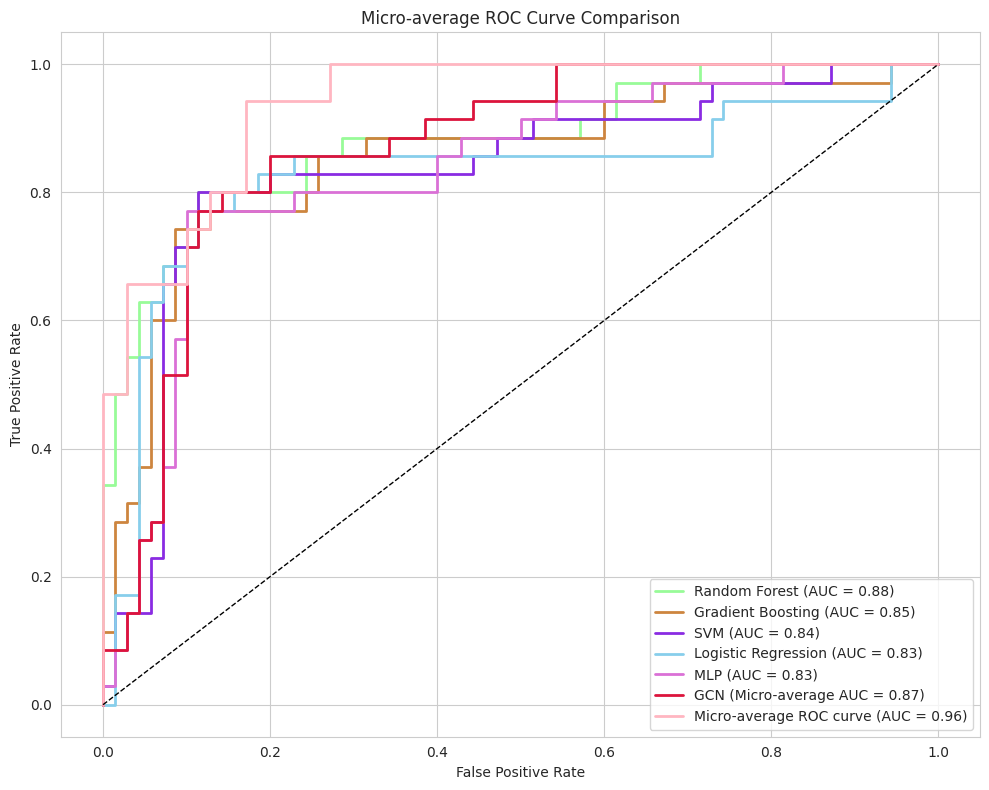

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=200, min_samples_split=5, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs", random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# 获取类别信息
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
colors = cycle(['palegreen', 'peru', 'blueviolet', 'skyblue', 'orchid'])

for (name, model), color in zip(models.items(), colors):
    print(f"Training {name} on full training set...")
    model.fit(X_train, y_train)

    if not hasattr(model, "predict_proba"):
        print(f"  Skipped {name} (no predict_proba method)")
        continue

    y_score = model.predict_proba(X_test)

    if y_score.shape[1] != n_classes:
        print(f"  Skipped {name} (incomplete class predictions)")
        continue

    # Compute micro-average ROC
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    micro_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, color=color, label=f"{name} (AUC = {micro_auc:.2f})")

micro_roc_df = pd.read_csv("GCN_Micro_ROC_Curve_Data.csv")
fpr_micro = micro_roc_df['FPR_micro']
tpr_micro = micro_roc_df['TPR_micro']
roc_auc_micro = micro_roc_df['AUC_micro'][0]  # Since AUC is the same for all entries

# Plot GCN micro-average ROC curve
plt.plot(
    fpr_micro,
    tpr_micro,
    lw=2,
    color="crimson",  # Use the last color for GCN
    label=f'GCN (Micro-average AUC = {roc_auc_micro:.2f})'
)
print(f"GCN Micro-average AUC: {roc_auc_micro:.2f}")

with open('gat_results.pkl', 'rb') as f:
    gat_results = pickle.load(f)

gat_fpr_micro = gat_results['micro']['fpr']
gat_tpr_micro = gat_results['micro']['tpr']
gat_micro_auc = gat_results['micro']['auc']

# Plot GAT macro-average ROC curve
plt.plot(gat_fpr_micro, gat_tpr_micro, color='lightpink', lw=2, label=f"Micro-average ROC curve (AUC = {roc_auc:.2f})")
print(f"GAT Macro-average AUC: {gat_micro_auc:.2f}")

# 画对角线
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("micro_avg_roc_curve.png")
plt.savefig("micro_avg_roc_curve.pdf")
plt.show()

In [ ]:
import shutil
from google.colab import files

# Step 1: Zip the folder
shutil.make_archive('cv_models_GAT_new', 'zip', 'cv_models_GAT_new')  # (output_name, format, source_folder)

# Step 2: Download the zipped folder
files.download('cv_models_GAT_new.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
from google.colab import files

# Step 1: Zip the folder
shutil.make_archive('cv_models_GCN_new', 'zip', 'cv_models_GCN_new')  # (output_name, format, source_folder)

# Step 2: Download the zipped folder
files.download('cv_models_GCN_new.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
from google.colab import files

# Step 1: Zip the folder
shutil.make_archive('saved_models', 'zip', 'saved_models')  # (output_name, format, source_folder)

# Step 2: Download the zipped folder
files.download('saved_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import zipfile
import os

# Define your paths
zip_path = 'cv_models_GAT_new copy.zip'
extract_dir = 'unzipped_models'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")

Extracted to: unzipped_models
